# Project 2
In this project we apply CART methods to the the Parkinson's classification dataset from Project 1, as well as to the Abalone dataset from the UCI machine learning repository.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier

import graphviz

from matplotlib.gridspec import GridSpec

In [38]:
figure_path = 'figures/'
dpi = 300

n_experiments = 100

## Exploratory data analysis
We begin by importing the Parkinsons' data. Summary visuals are omitted, since these were considered in Project 1.

In [39]:
raw_data = pd.read_csv('../data/parkinsons/train_data.txt', header=None)
raw_data = raw_data.drop([0, 27], axis=1)
raw_data[[20]] = raw_data[[20]].astype('float64')
raw_data[[21]] = raw_data[[21]].astype('float64')
raw_data[[25]] = raw_data[[25]].astype('float64')
raw_data[[28]] = raw_data[[28]].astype('int64')

We recall that the dataset is balanced, in that we have an equal number of examples of each class. This will facilitate training later on. The distribution of the 25 input variables is also highly overlapped.

In [40]:
X = raw_data.loc[:,:26].values
y = raw_data[[28]].values.ravel()

In [41]:
X_scaled = preprocessing.scale(X)

In [42]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(
                                    X_scaled, y, test_size=0.20, random_state=42)

Next we import the Abalone data, available [here](https://archive.ics.uci.edu/ml/datasets/Abalone) from the UCI Machine Learning Repository.

In [43]:
raw_data = pd.read_csv('../data/abalone/abalone.data', header=None)
abalone_headers = ['Sex', 'Length', 'Diameter', 'Height',
                  'Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight',
                  'Rings']
raw_data.columns = abalone_headers

The target response variable is the number of rings.

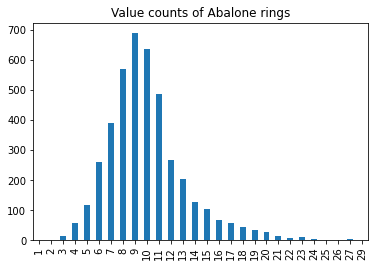

In [44]:
raw_data['Rings'].value_counts().sort_index().plot(kind='bar', title='Value counts of Abalone rings')
plt.savefig(figure_path + 'valuecounts.png', dpi=dpi, bbox_inches='tight')
plt.show()

Unfortunately, this dataset is nowhere near balanced and there are far too many classes for a reasonable level of performance. We will hence map the number of rings to a three-class classification problem.

In [45]:
raw_data['Class'] = np.where(raw_data['Rings'] <= 8, 0, 1)
raw_data['Class'] = np.where(raw_data['Rings'] >= 11, 2, raw_data['Class'])

In [46]:
encoder = preprocessing.OneHotEncoder(sparse=False)
sexes = encoder.fit_transform(raw_data['Sex'].values.reshape(-1,1))

In [47]:
X = np.hstack([sexes, raw_data.iloc[:,1:7].values])
y = raw_data[['Class']].values.ravel()

However, there is also a large amount of overlap between the classes.

In [48]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X[:,3:])

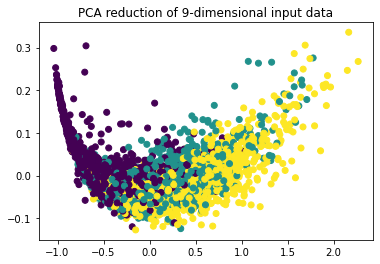

In [49]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y)
plt.title('PCA reduction of 9-dimensional input data')
plt.savefig(figure_path + 'pca.png', dpi=dpi, bbox_inches='tight')
plt.show()

In [50]:
Xa_train, Xa_test, ya_train, ya_test = train_test_split(
                                    X, y, test_size=0.20, random_state=42)

## An out-of-the-box implementation
Recalling that logistic regression and a support vector machine delivered $69\%$ and $73\%$ classification accuracy, respectively, we first experiment with an out-of-the-box decision tree classifier on the Parkinson's dataset.

In [15]:
scores = []

for n in range(n_experiments):
    model = DecisionTreeClassifier()
    model.fit(Xp_train, yp_train)
    scores.append(model.score(Xp_test, yp_test))

print(np.mean(scores))

0.6559615384615387


This benchmark of $65\%$ is not great and suggests we will need to tailor several hyperparameters if we are to attain a reasonable level of performance. What about a benchmark for the Abalone dataset?

In [16]:
scores = []

for n in range(n_experiments):
    model = DecisionTreeClassifier()
    model.fit(Xa_train, ya_train)
    scores.append(model.score(Xa_test, ya_test))

print(np.mean(scores))

0.5938995215311006


At $59\%$ classification accuracy, benchmark performance is again low. Significant improvement will be required.

## Experimentation
1. Report the Tree Visualisation (show your tree and also translate few selected nodes and leaves into IF and Then rules)
2. Do an investigation about improving performance further by pruning the tree: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
3. Apply Bagging of Trees via Random Forests and show performance as your number of trees in the ensembles increases. Carry out 10 experiments in Part 1 and 3 and show performance with mean and confidence interval. Note Part 1 may have same results for every experimental run. 
4. Compare results with Adam and SGD and discuss them.

### Visualisations of the Tree
A significant advantage of tree-based methods is that the internal logic of the trained model can be clearly visualised in a graph. To do so however, we will first reduce the maximum number of leaf nodes to make it easier to plot.

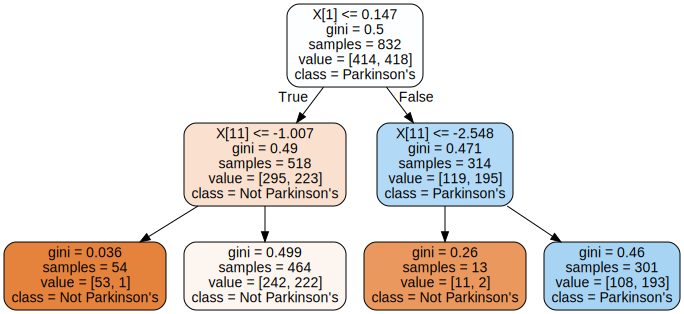

In [17]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(Xp_train, yp_train)


dot_data = tree.export_graphviz(model, out_file=None,
                                class_names=["Not Parkinson's", "Parkinson's"],
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render("figures/e1_parkinsons")
graph

We can also render the tree as text, which makes the if-else structure of the tree more explicit.

In [18]:
r = tree.export_text(model)
print(r)

|--- feature_1 <= 0.15
|   |--- feature_11 <= -1.01
|   |   |--- class: 0
|   |--- feature_11 >  -1.01
|   |   |--- class: 0
|--- feature_1 >  0.15
|   |--- feature_11 <= -2.55
|   |   |--- class: 0
|   |--- feature_11 >  -2.55
|   |   |--- class: 1



Next we do the same for the Parkinson's dataset.

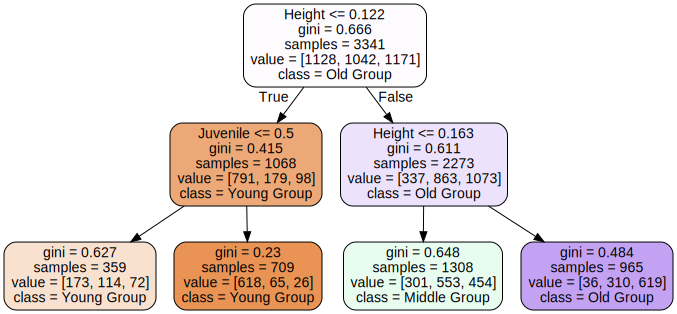

In [19]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(Xa_train, ya_train)

feature_names = ['Female', 'Juvenile', 'Male'] + raw_data.iloc[:,1:7].columns.tolist()

dot_data = tree.export_graphviz(model, out_file=None, 
                                class_names=['Young Group', 'Middle Group', 'Old Group'],
                                feature_names=feature_names,
                                filled=True, rounded=True)  
graph = graphviz.Source(dot_data)
graph.render("figures/e1_abalone")
graph 

In [20]:
r = tree.export_text(model, feature_names=feature_names)
print(r)

|--- Height <= 0.12
|   |--- Juvenile <= 0.50
|   |   |--- class: 0
|   |--- Juvenile >  0.50
|   |   |--- class: 0
|--- Height >  0.12
|   |--- Height <= 0.16
|   |   |--- class: 1
|   |--- Height >  0.16
|   |   |--- class: 2



### Pruning the Tree
Having visualised the tree structure, we next experiment with pruning the tree. This is controlled by the cost complexity parameter, which effectively trades off the number of terminal nodes with the total misclassification rate of the terminal nodes. The effects of variations to this parameter are most clear when we compare training and testing performance, starting with the Parksinson's dataset.

In [21]:
alphas = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.05, 0.075, 0.1]

In [22]:
training_scores = []
test_scores = []
test_sds = []

for alpha in alphas:
    training_score = []
    test_score = []
    for n in range(n_experiments):
        model = DecisionTreeClassifier(ccp_alpha=alpha)
        model.fit(Xp_train, yp_train)
        training_score.append(model.score(Xp_train, yp_train))
        test_score.append(model.score(Xp_test, yp_test))
    training_score = np.mean(training_score)
    test_sd = np.std(test_score)
    test_score = np.mean(test_score)
    
    training_scores.append(training_score)
    test_scores.append(test_score)
    test_sds.append(test_sd)

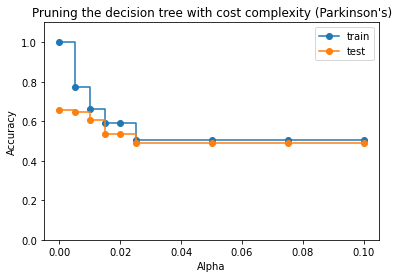

In [23]:
plt.plot(alphas, training_scores, marker='o', drawstyle='steps-post', label='train')
plt.plot(alphas, test_scores, marker='o', drawstyle='steps-post', label='test')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.legend(loc="upper right")
plt.title("Pruning the decision tree with cost complexity (Parkinson's)")
plt.savefig('e2_parkinsons.png', dpi=dpi, bbox_inches='tight')
plt.show()

In [24]:
pd.DataFrame({'Alpha': alphas, 'Test Score': test_scores, 'Test Std Dev': test_sds})

,Alpha,Test Score,Test Std Dev
0,0.000,0.654615,1.384615e-02
1,0.005,0.644231,1.110223e-16
2,0.010,0.605769,1.110223e-16
3,0.015,0.533654,1.110223e-16
4,0.020,0.533654,1.110223e-16
5,0.025,0.490385,1.665335e-16
6,0.050,0.490385,1.665335e-16
7,0.075,0.490385,1.665335e-16
8,0.100,0.490385,1.665335e-16


We then perform the same analysis for the Abalone dataset.

In [25]:
training_scores = []
test_scores = []
test_sds = []

for alpha in alphas:
    training_score = []
    test_score = []
    for n in range(n_experiments):
        model = DecisionTreeClassifier(ccp_alpha=alpha)
        model.fit(Xa_train, ya_train)
        training_score.append(model.score(Xa_train, ya_train))
        test_score.append(model.score(Xa_test, ya_test))
    training_score = np.mean(training_score)
    test_sd = np.std(test_score)
    test_score = np.mean(test_score)
    
    training_scores.append(training_score)
    test_scores.append(test_score)
    test_sds.append(test_sd)

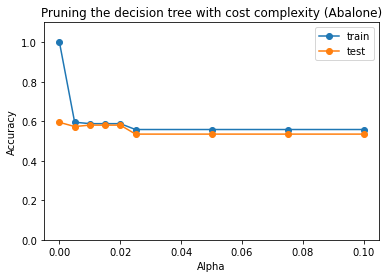

In [26]:
plt.plot(alphas, training_scores, marker='o', label='train')
plt.plot(alphas, test_scores, marker='o', label='test')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.legend(loc="upper right")
plt.title("Pruning the decision tree with cost complexity (Abalone)")
plt.savefig('e2_abalone.png', dpi=dpi, bbox_inches='tight')
plt.show()

In [27]:
pd.DataFrame({'Alpha': alphas, 'Test Score': test_scores, 'Test Std Dev': test_sds})

,Alpha,Test Score,Test Std Dev
0,0.000,0.594294,6.090044e-03
1,0.005,0.572967,2.220446e-16
2,0.010,0.580144,0.000000e+00
3,0.015,0.580144,0.000000e+00
4,0.020,0.580144,0.000000e+00
5,0.025,0.534689,1.110223e-16
6,0.050,0.534689,1.110223e-16
7,0.075,0.534689,1.110223e-16
8,0.100,0.534689,1.110223e-16


### Random Forests
Next we construct an ensemble of trees into a forest and explore the relationship between number of trees and classification performance. This is done first for the Parkinson's dataset.

In [28]:
forest_sizes = [1, 10, 50, 100, 500]

In [29]:
training_scores = []
test_scores = []
test_sds = []

for n_trees in forest_sizes:
    training_score = []
    test_score = []
    for n in range(n_experiments):
        model = RandomForestClassifier(n_estimators=n_trees)
        model.fit(Xp_train, yp_train)
        training_score.append(model.score(Xp_train, yp_train))
        test_score.append(model.score(Xp_test, yp_test))
    training_score = np.mean(training_score)
    test_sd = np.std(test_score)
    test_score = np.mean(test_score)
    
    training_scores.append(training_score)
    test_scores.append(test_score)
    test_sds.append(test_sd)

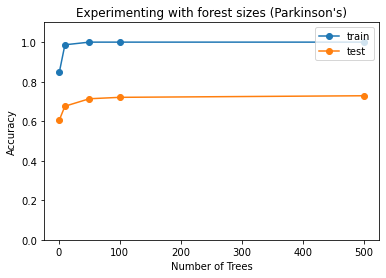

In [30]:
plt.plot(forest_sizes, training_scores, marker='o', label='train')
plt.plot(forest_sizes, test_scores, marker='o', label='test')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.legend(loc="upper right")
plt.title("Experimenting with forest sizes (Parkinson's)")
plt.savefig('e3_parkinsons.png', dpi=dpi, bbox_inches='tight')
plt.show()

In [31]:
pd.DataFrame({'Forest Sizes': forest_sizes, 'Test Score': test_scores, 'Test Std Dev': test_sds})

,Forest Sizes,Test Score,Test Std Dev
0,1,0.607356,0.033565
1,10,0.675721,0.025606
2,50,0.713510,0.017874
3,100,0.720721,0.015250
4,500,0.728702,0.011483


We then perform the same analysis for the Abalone dataset.

In [32]:
training_scores = []
test_scores = []
test_sds = []

for n_trees in forest_sizes:
    training_score = []
    test_score = []
    for n in range(n_experiments):
        model = RandomForestClassifier(n_estimators=n_trees)
        model.fit(Xa_train, ya_train)
        training_score.append(model.score(Xa_train, ya_train))
        test_score.append(model.score(Xa_test, ya_test))
    training_score = np.mean(training_score)
    test_sd = np.std(test_score)
    test_score = np.mean(test_score)
    
    training_scores.append(training_score)
    test_scores.append(test_score)
    test_sds.append(test_sd)

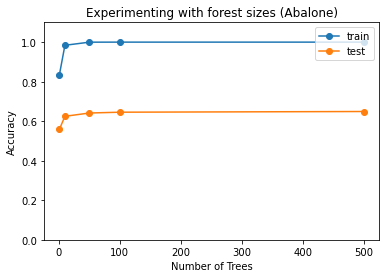

In [33]:
plt.plot(forest_sizes, training_scores, marker='o', label='train')
plt.plot(forest_sizes, test_scores, marker='o', label='test')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.legend(loc="upper right")
plt.title("Experimenting with forest sizes (Abalone)")
plt.savefig('e3_abalone.png', dpi=dpi, bbox_inches='tight')
plt.show()

In [34]:
pd.DataFrame({'Forest Sizes': forest_sizes, 'Test Score': test_scores, 'Test Std Dev': test_sds})

,Forest Sizes,Test Score,Test Std Dev
0,1,0.559151,0.015831
1,10,0.624725,0.010851
2,50,0.641364,0.008135
3,100,0.645514,0.006219
4,500,0.649019,0.005044


### Comparisons with Neural Networks
How does performance compare with neural networks? In the case of the Parkinson's dataset, not well. No new code is required here, so we leave the discussion to the report document.